In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


# carregar arquivo .mat
mat = loadmat('in_out_SBRT2_direto.mat')

in_data_ext = mat['in_extraction']
out_data_ext = mat['out_extraction']
in_data_val = mat['in_validation']
out_data_val = mat['out_validation']


lista = [in_data_ext, out_data_ext, in_data_val, out_data_val]

modulos = []
for i in lista:
    modulos.append(max(i.imag))
    modulos.append(max(i.real))

maior_modulo = max(modulos)

in_ext_norm   = in_data_ext/maior_modulo
out_ext_norm  = out_data_ext/maior_modulo
in_val_norm   = in_data_val/maior_modulo
out_val_norm = out_data_val/maior_modulo

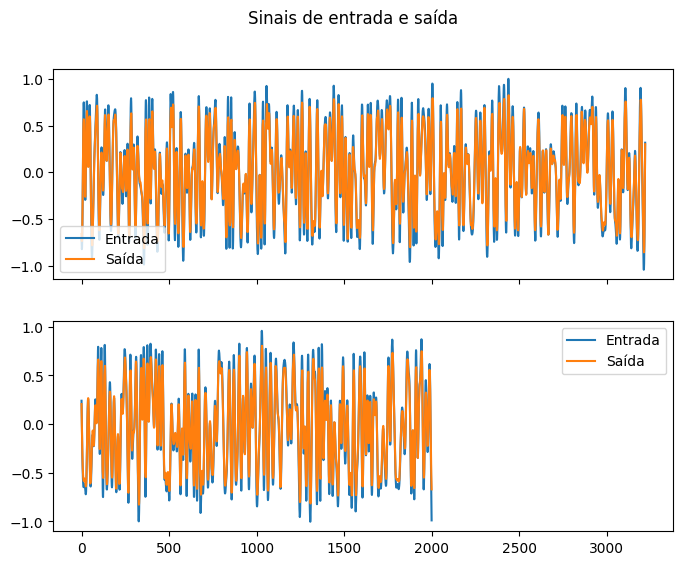

In [3]:
# plotar sinais de entrada e saída
x_ext = range(len(in_data_ext))
x_val = range(len(in_data_val))

fig, axs = plt.subplots(2, sharex=True, figsize=(8, 6))
fig.suptitle('Sinais de entrada e saída')
axs[0].plot(x_ext, np.real(in_ext_norm), label='Entrada')
axs[0].plot(x_ext, np.real(out_ext_norm), label='Saída')
axs[0].legend()
axs[1].plot(x_val, np.real(in_val_norm), label='Entrada')
axs[1].plot(x_val, np.real(out_val_norm), label='Saída')
axs[1].legend()
plt.show()

In [6]:
import numpy as np

def mp(P, M, xn):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                XX[l-M-1, ((p-1)*(M+1))+m] = np.abs(xn[l-m]**(2*p-2))*(xn[l-m])
    return XX

P = 5
M = 1

XX_ext_norm = mp(P, M, in_ext_norm)
coefficients_norm, _, _, _ = np.linalg.lstsq(XX_ext_norm, out_ext_norm[M:], rcond=None)

XX_val = mp(P, M, in_val_norm)

In [7]:
bits_precisao = [2, 4, 6, 8, 10]  # Exemplo de quantidade de bits para a precisão
bits_extras = [2, 3, 4, 5, 6]  # Exemplo de quantidade de bits extras para evitar overflow

nmse_values = []

def ProdutoVirgulaFixa(XX,Coefcients):
    

for p_bits, e_bits in zip(bits_precisao, bits_extras):
    # Converter para vírgula fixa
    in_val_fixed = np.round(in_val_norm * 2**p_bits) / 2**p_bits
    out_val_fixed = np.round(out_val_norm * 2**p_bits) / 2**p_bits

    # Calcular o NMSE
    predicted_val_fixed = XX_val @ coefficients_norm
    nmse_fixed = 10 * np.log10(np.mean(np.abs(out_val_fixed[M:] - predicted_val_fixed) ** 2) / np.mean(np.abs(out_val_fixed[M:]) ** 2))

    # Levar em consideração os bits extras para evitar overflow
    total_bits = p_bits + 1 + e_bits
    nmse_values.append((total_bits, nmse_fixed))


In [10]:
for bits, nmse in nmse_values:
    print(f"Bits: {bits}\tNMSE: {nmse} dB")

Bits: 5	NMSE: -14.249080381113263 dB
Bits: 8	NMSE: -22.070994029120264 dB
Bits: 11	NMSE: -23.632008720474506 dB
Bits: 14	NMSE: -23.729848087315624 dB
Bits: 17	NMSE: -23.738247656771282 dB


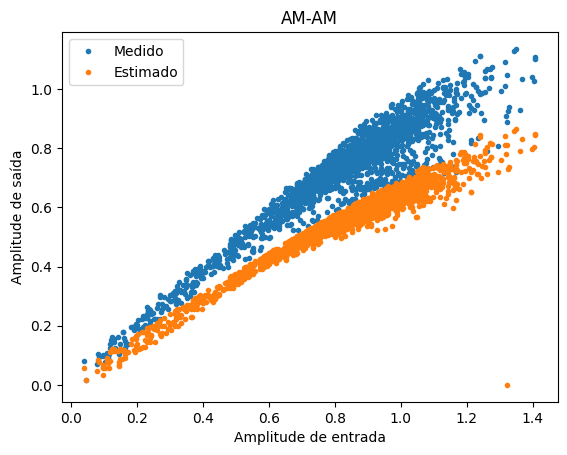

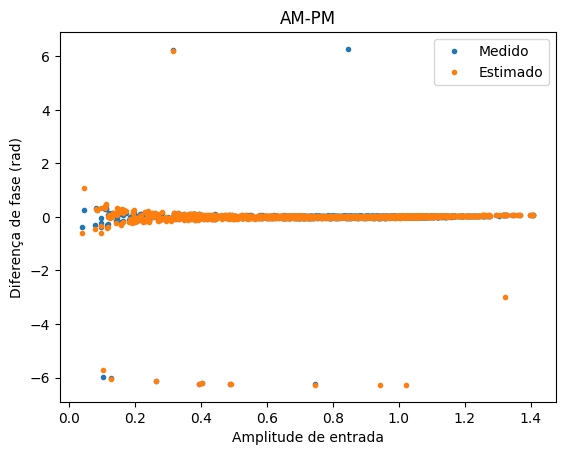

In [11]:
# Gráficos AM-AM e AM-PM
plt.figure()
plt.plot(np.abs(in_data_val[M:]), np.abs(out_data_val[M:]), '.', label='Medido')
plt.plot(np.abs(in_data_val[M:]), np.abs(predicted_val_fixed), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.figure()
plt.plot(np.abs(in_data_val[M:]), np.angle(out_data_val[M:])-np.angle(in_data_val[M:]), '.', label='Medido')
plt.plot(np.abs(in_data_val[M:]), np.angle(predicted_val_fixed)-np.angle(in_data_val[M:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Diferença de fase (rad)')
plt.title('AM-PM')
plt.legend()